# Machine Learning Assignment 2
- *Suneha Sen MDS202351*
- *Sayantani Saha MDS202345*


# Importing libraries


In [3]:
! pip install memory_profiler

In [4]:
%load_ext memory_profiler

In [5]:
import os
import urllib.request
import gzip
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
seed=42


# Datasets


In [6]:
def get_data(name):
    # Check if data files exist, if not, download them
    if not os.path.isfile(f"docword.{name}.txt"):
        urllib.request.urlretrieve(f"https://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/docword.{name}.txt.gz", f"docword.{name}.txt.gz")
        with gzip.open(f"docword.{name}.txt.gz", 'rb') as f_in:
            with open(f"docword.{name}.txt", 'wb') as f_out:
                f_out.write(f_in.read())

    if not os.path.isfile(f"vocab.{name}.txt"):
        urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/vocab.{}.txt".format(name), "vocab.{}.txt".format(name))

    # Fetching vocabulary
    vocab = np.array(open(f"vocab.{name}.txt", "r").read().split("\n"))

    # Fetching data
    data = np.array(
        list(
            map(lambda x: [int(i) for i in x.split(" ")],
                open(f"docword.{name}.txt", "r").read().split("\n")[3:-1])),
        dtype=np.int64)

    # Creating Dataframe
    df = pd.DataFrame(data, columns=["docID", "wordID", "count"])

    # Adding words to the dataset
    df['word'] = df['wordID'].apply(lambda id: vocab[id-1])

    # Converting docID to 0-index
    df['docID'] = df['docID'].apply(lambda x: x-1)

    # Change Column Orders
    df = df[["word", "docID", "wordID", "count"]]

    # Clustering Data for K-Means
    df_cluster = df.groupby("docID").agg({'wordID': lambda x: set(x)}).to_dict()["wordID"]
    df_cluster = [df_cluster[i] for i in range(len(df_cluster))]

    return df, np.array(df_cluster)

# Plotting Utility

In [8]:
def elbow_plot(X,max_cluster=10):
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, max_cluster)]
    inertias = [model.inertia_ for model in kmeans_per_k]
    plt.figure(figsize=(15, 5))

    plt.subplot(1,2,1)
    plt.plot(range(1, max_cluster), inertias, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Inertia", fontsize=14)

    silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]
    plt.subplot(1,2,2)
    plt.plot(range(2, max_cluster), silhouette_scores, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Silhouette score", fontsize=14)

    plt.show()

def matrix_plot(mat,y,k):
    # Group data points of cluster together
    B = np.vstack([mat[y == i] for i in range(k)])

    # Plotting the matrix
    plt.figure(figsize=(15,8))

    plt.subplot(1, 2, 1)
    plt.imshow(mat, cmap="gray")
    plt.title("UnClustered Data")

    plt.subplot(1, 2, 2)
    plt.imshow(B, cmap="gray")
    for j in np.cumsum([len(mat[y == i]) for i in range(k)]):
        plt.plot([0, mat.shape[0]], [j, j])
    plt.title("Clustered Data")

    plt.show()

def PCA_plot(X, cls_marker, ax):
    pca=PCA(3)
    X_new= pca.fit_transform(X)
    i_1, i_2, i_3 = pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1], pca.explained_variance_ratio_[2]

    for id in range(cls_marker.min(), cls_marker.max()+1):
        idx = (cls_marker == id)
        ax.scatter(X_new[idx,0], X_new[idx,1], X_new[idx,2] ,alpha=0.7, label=f"Cluster-{id+1}")
    ax.set_xlabel(f"Principle Component I: {np.round(100*i_1, 3)}%")
    ax.set_ylabel(f"Principle Component II: {np.round(100*i_2, 3)}%")
    ax.set_zlabel(f"Principle Component III: {np.round(100*i_3, 3)}%")
    ax.legend()
    ax.set_title(f"PCA-Plot\nTotal Information Preserved: {np.round(100*(i_1+i_2+i_3), 3)}%")

    return ax

def TSNE_plot(X, cls_marker, perplexity=40, n_iter=250, ax=None):
    tsne = TSNE(n_components=3, init='pca', random_state=0, perplexity= perplexity, n_iter=n_iter)
    X_new = tsne.fit_transform(X)
    for id in range(cls_marker.min(), cls_marker.max()+1):
        idx = (cls_marker == id)
        ax.scatter(X_new[idx,0], X_new[idx,1], X_new[idx,2] ,alpha=0.7, label=f"Cluster-{id+1}")
    ax.legend()
    ax.set_title('t-SNE Plot')

    return ax

def joint_plot(X, cls_marker, pca_perplexity=40, pca_n_iter=250, tsne_perplexity=40, tsne_n_iter=250):
    fig = plt.figure(figsize=(18, 6))

    ax1=fig.add_subplot(121, projection="3d")
    PCA_plot(X, cls_marker, ax1)
    ax2 = fig.add_subplot(122, projection="3d")
    TSNE_plot(X, cls_marker, tsne_perplexity, n_iter=tsne_n_iter, ax=ax2)

    plt.tight_layout()

    plt.show()

# Functions

In [9]:
# Calculate Jaccard index for two points
jacc_dist = lambda x, y: 1-(len(x.intersection(y)) / len(x.union(y)))

# Closest point to a in set of points B
closest = lambda a, B: np.argmin(np.sum((a-B)**2, axis=1))

# Jaccard Distance Matrix
def jaccard_dist_mat(clusters):
    dim=len(clusters)
    mat=np.zeros([dim,dim])
    for i in range(dim):
        for j in range(i,dim):
            temp=jacc_dist(clusters[i],clusters[j])
            mat[i,j],mat[j,i]=temp,temp
    return mat


In [10]:
# display docID and wordID after clustering
def id_Print(mat,centers,df_cls):
    print('Clusters:')
    centroid_docs_id = [closest(mat, cx) for cx in centers]
    for i, x in enumerate(centroid_docs_id):
        print(f"Centroid-{i+1}: DocID-{x} -> {df_cls[x]}")

# display metrics
def evaluation_metrics(X,labels):
    print('\n\nEvaluation Metrics:')
    print(f"Davies-Bouldin Score = {davies_bouldin_score(X,labels):0.6f}")
    print(f"Calinski-Harabasz Score = {calinski_harabasz_score(X, labels):0.6f}")
    print(f"Silhouette Score = {silhouette_score(X,labels):0.6f}")

# KOS Doc

In [11]:
%%time
%%memit
# Organizing Data

df_kos, cls_kos= get_data('kos')
mat = jaccard_dist_mat(cls_kos)
df_kos.head()

peak memory: 462.26 MiB, increment: 147.31 MiB
CPU times: user 1min 18s, sys: 471 ms, total: 1min 18s
Wall time: 1min 20s


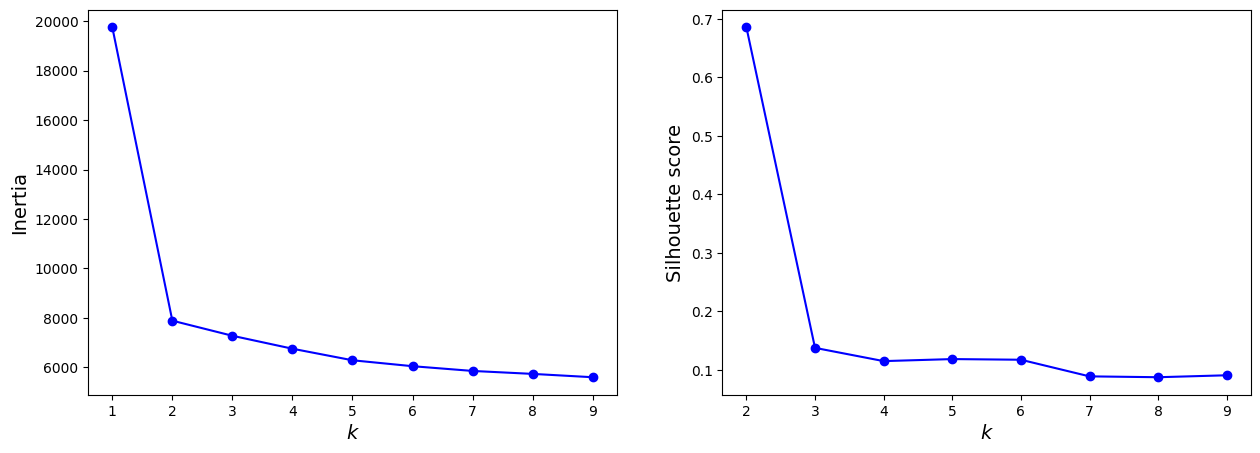

In [12]:
# Elbow Plots
elbow_plot(mat)

In [13]:
%%time
%%memit
# Clustering
k = 2
kmeans = KMeans(n_clusters=k,
                init = 'k-means++',
                n_init = 10,
                max_iter = 300,
                tol = 1e-04,
                random_state = seed)

y_pred = kmeans.fit_predict(mat)

peak memory: 580.07 MiB, increment: 106.30 MiB
CPU times: user 3.6 s, sys: 681 ms, total: 4.28 s
Wall time: 3.49 s


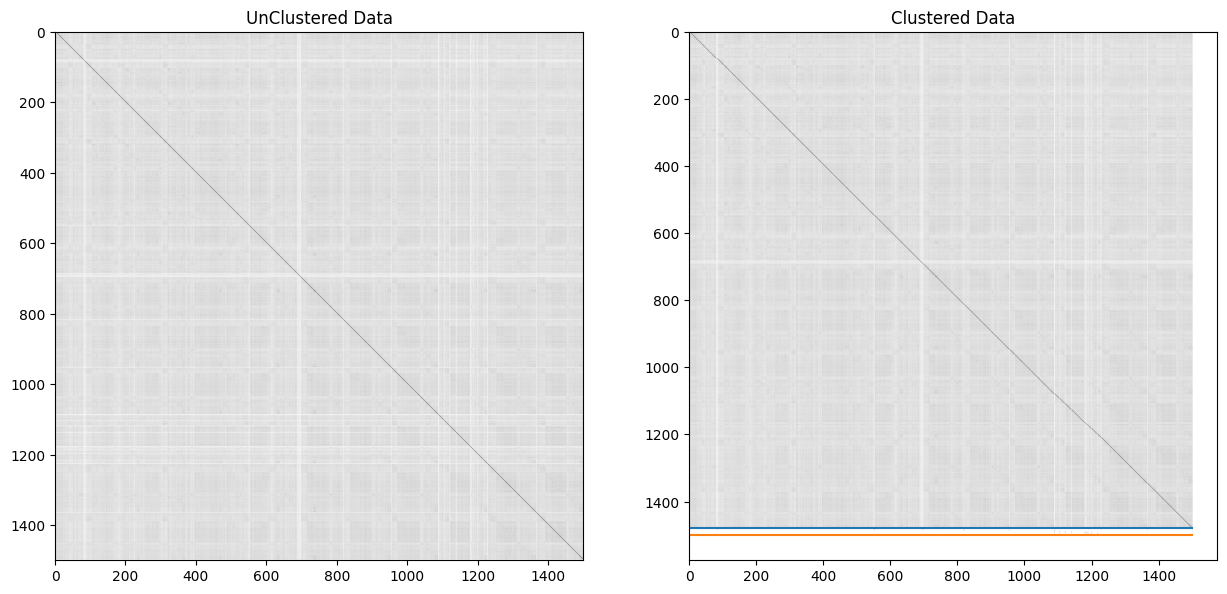

In [ ]:
# Visualize Clustering in Distance Matrix
matrix_plot(mat, y_pred,k)

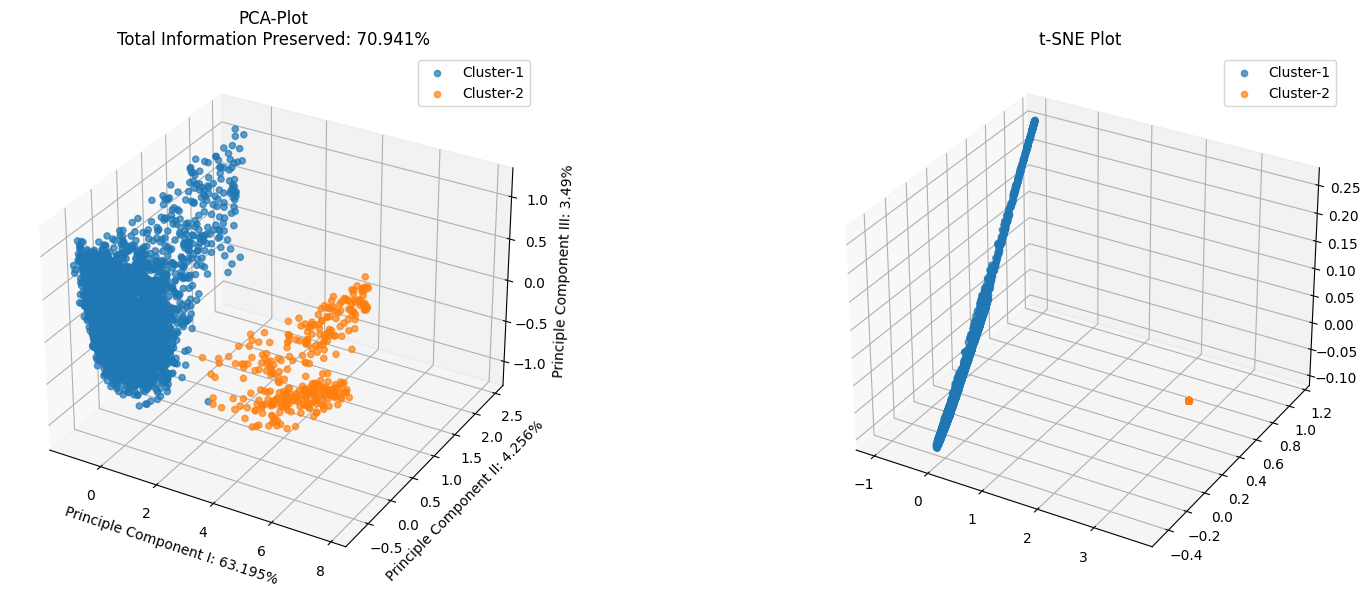

peak memory: 568.44 MiB, increment: 94.29 MiB
CPU times: user 1min 10s, sys: 1.14 s, total: 1min 11s
Wall time: 43.9 s


In [14]:
%%time
%%memit
# Document Clustering Visualization
joint_plot(mat, y_pred)

In [15]:
id_Print(mat,kmeans.cluster_centers_,cls_kos)
evaluation_metrics(mat,y_pred)

Clusters:
Centroid-1: DocID-499 -> {3082, 3594, 6157, 2576, 4631, 4632, 1052, 2081, 3620, 6700, 46, 3630, 3124, 6711, 3644, 6204, 2110, 6206, 3660, 1102, 2640, 594, 1619, 4185, 4191, 614, 6762, 4715, 621, 3696, 625, 6256, 639, 134, 1677, 5777, 1173, 1177, 4769, 1698, 3750, 3752, 4779, 1708, 6315, 174, 6319, 1714, 2743, 6333, 2238, 4801, 708, 2759, 6347, 5326, 723, 5338, 4317, 2271, 2275, 4323, 2278, 2792, 3306, 238, 241, 2808, 248, 2815, 260, 3849, 4874, 4880, 3858, 5909, 1304, 1311, 2335, 6434, 2341, 3877, 5418, 4398, 3893, 3384, 2878, 5952, 841, 4941, 1358, 6480, 5970, 339, 855, 3420, 5469, 862, 2401, 2404, 2917, 1894, 4456, 2409, 3433, 364, 1389, 4978, 2932, 3444, 4470, 4980, 6006, 6009, 2426, 5499, 2946, 2962, 5011, 916, 1946, 1947, 3998, 4521, 2991, 5039, 3506, 5043, 1461, 5045, 6586, 1467, 4027, 445, 1477, 4037, 1992, 5576, 4042, 4043, 2516, 2005, 5592, 5593, 3549, 4062, 3039, 3040, 6624, 4073, 6633, 1516, 3066, 6651, 3069}
Centroid-2: DocID-824 -> {6659, 6660, 6661, 1030, 3591, 

# NIPS Doc

In [16]:
%%time
%%memit
# Loading Data in Required Format
df_nips, cls_nips= get_data('nips')
mat = jaccard_dist_mat(cls_nips)
df_nips.head()

peak memory: 635.09 MiB, increment: 155.37 MiB
CPU times: user 1min 27s, sys: 828 ms, total: 1min 27s
Wall time: 1min 38s


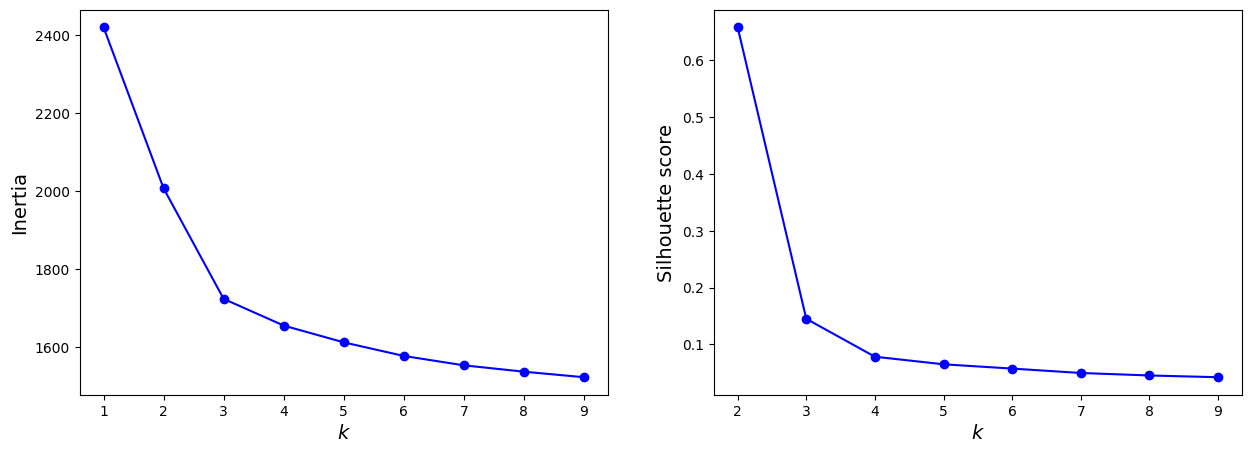

In [17]:
elbow_plot(mat)

In [28]:
%%time
%%memit
# Clustering

k = 3
kmeans = KMeans(n_clusters = k,
                init = 'k-means++',
                n_init = 10,
                max_iter = 300,
                tol = 1e-04,
                random_state = seed)

y_pred = kmeans.fit_predict(mat)

peak memory: 1665.51 MiB, increment: 0.14 MiB
CPU times: user 4.19 s, sys: 458 ms, total: 4.65 s
Wall time: 6.29 s


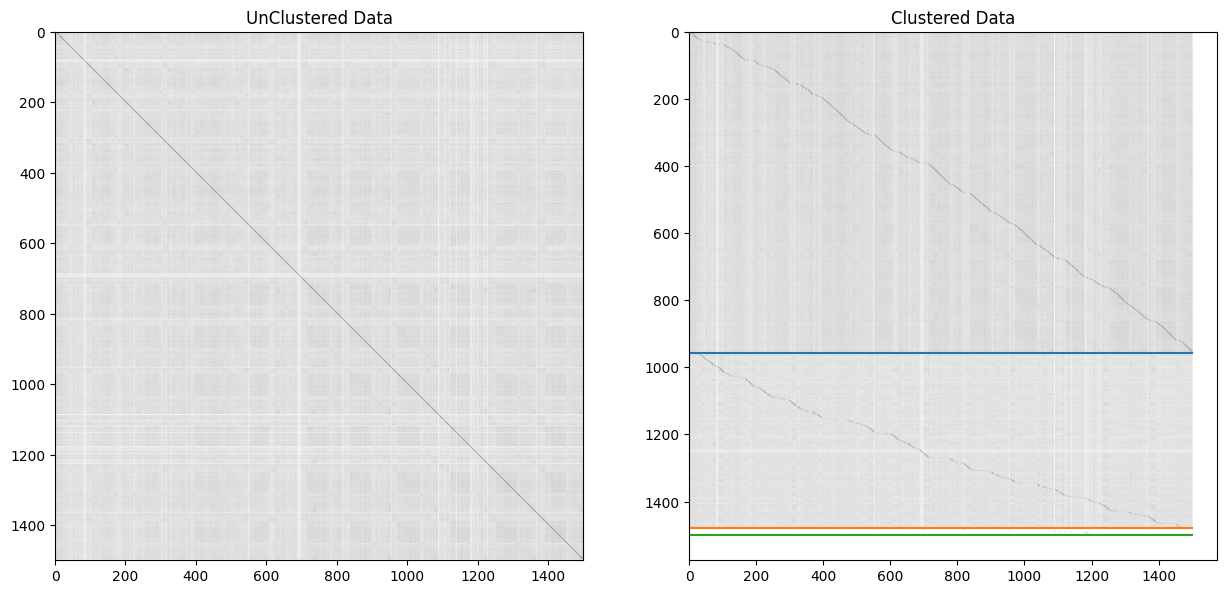

In [29]:
# Visualize Clustering in Distance Matrix

matrix_plot(mat, y_pred, k)

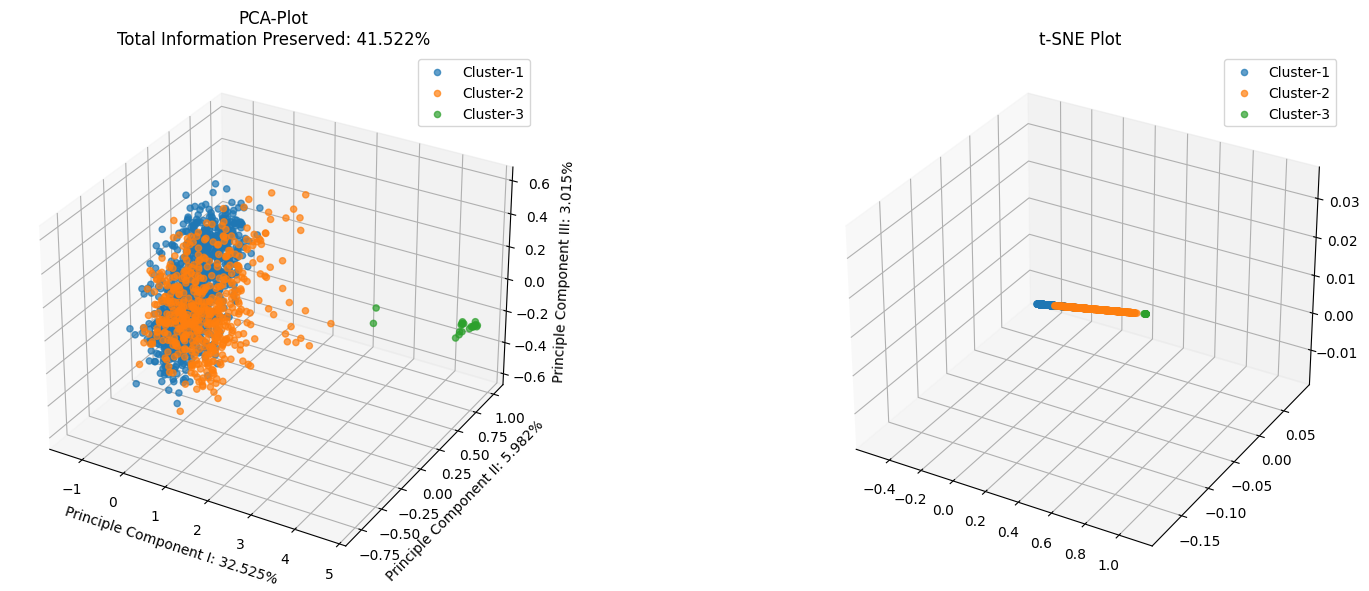

peak memory: 1665.52 MiB, increment: 0.01 MiB
CPU times: user 13.3 s, sys: 796 ms, total: 14.1 s
Wall time: 9.16 s


In [30]:
%%time
%%memit
# Document Clustering Visualization

joint_plot(mat, y_pred)





In [31]:
id_Print(mat, kmeans.cluster_centers_, cls_nips)
evaluation_metrics(mat, y_pred)

Clusters:
Centroid-1: DocID-931 -> {10242, 2051, 8197, 10245, 2056, 10254, 4112, 4114, 6163, 6181, 39, 2087, 4146, 12340, 4155, 4156, 4159, 10305, 6212, 4165, 2118, 12359, 2129, 4180, 6229, 4182, 87, 88, 6235, 6237, 12383, 8289, 101, 2149, 4199, 6245, 10342, 107, 6252, 6255, 10354, 4220, 2175, 10368, 10372, 133, 2182, 2187, 141, 2202, 2203, 2204, 2205, 164, 165, 2217, 170, 4267, 4268, 2221, 4270, 8370, 6329, 10429, 4286, 193, 4296, 6358, 6361, 4315, 2268, 8421, 8427, 8431, 8433, 4347, 6402, 10501, 6410, 274, 8466, 4383, 4386, 2341, 8485, 10533, 2350, 2353, 10549, 2358, 316, 8508, 8511, 8512, 8513, 6468, 10567, 2378, 2379, 10570, 6477, 6479, 6481, 10578, 8531, 2396, 2397, 8540, 8548, 8551, 360, 362, 4463, 8561, 4467, 4468, 374, 4471, 4472, 10620, 8575, 393, 8585, 398, 8600, 6554, 2461, 421, 2469, 428, 8622, 10671, 10675, 8628, 4534, 8630, 4536, 8632, 8634, 8637, 447, 8640, 2498, 2503, 4553, 10700, 10703, 4568, 475, 10715, 10720, 4577, 10721, 10723, 10734, 497, 507, 6654, 8706, 10765, 25

# Enron Doc

In [21]:
%%time
%%memit
# Loading data in Required Format

df_enron, cls_enron= get_data('enron')
df_enron.head()

peak memory: 1621.85 MiB, increment: 1058.24 MiB
CPU times: user 18.3 s, sys: 2.67 s, total: 21 s
Wall time: 55.7 s


In [22]:
# storing lengths of all documents
ln_enron = np.array([len(x) for x in cls_enron])

# Removing those documents for which there is no other document with same length.
len_dict = Counter(ln_enron)
length_tbr = [x for x in len_dict if len_dict[x] <=1]

non_strat = [i for i, x in enumerate(cls_enron) if len(x) in length_tbr]

non_strat_idx = np.array([True]*len(cls_enron))
non_strat_idx[non_strat] = False

# taking stratified sample based on document size
cd_enron_1, _ , cd_enron_2 , _   = train_test_split(cls_enron[non_strat_idx],
                                                    ln_enron[non_strat_idx],
                                                    stratify=ln_enron[non_strat_idx],
                                                    test_size=0.9)


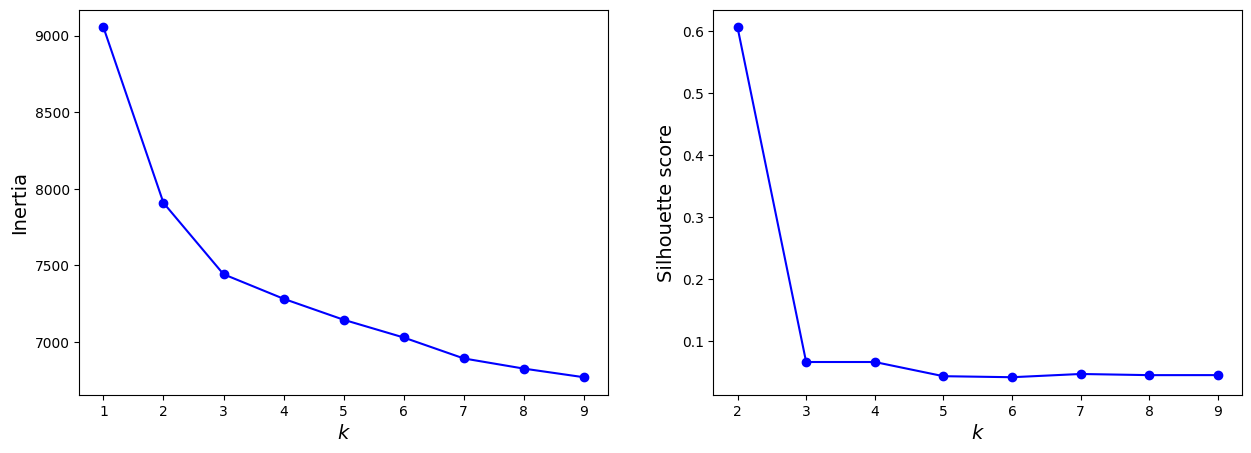

peak memory: 1902.32 MiB, increment: 357.80 MiB
CPU times: user 5min 13s, sys: 11.4 s, total: 5min 25s
Wall time: 3min 54s


In [23]:
%%time
%%memit
# Calculating Distance Matrix
enron_matrix = jaccard_dist_mat(cd_enron_1)

# Elbow and silhouette plot
elbow_plot(enron_matrix)

In [24]:
%%time
%%memit
# Clustering

k = 2
kmeans = KMeans(n_clusters = k,
                init = 'k-means++',
                n_init = 10,
                max_iter = 300,
                tol = 1e-04,
                random_state = seed)

y_pred = kmeans.fit_predict(enron_matrix)

peak memory: 1903.20 MiB, increment: 238.55 MiB
CPU times: user 10.6 s, sys: 808 ms, total: 11.4 s
Wall time: 8.75 s


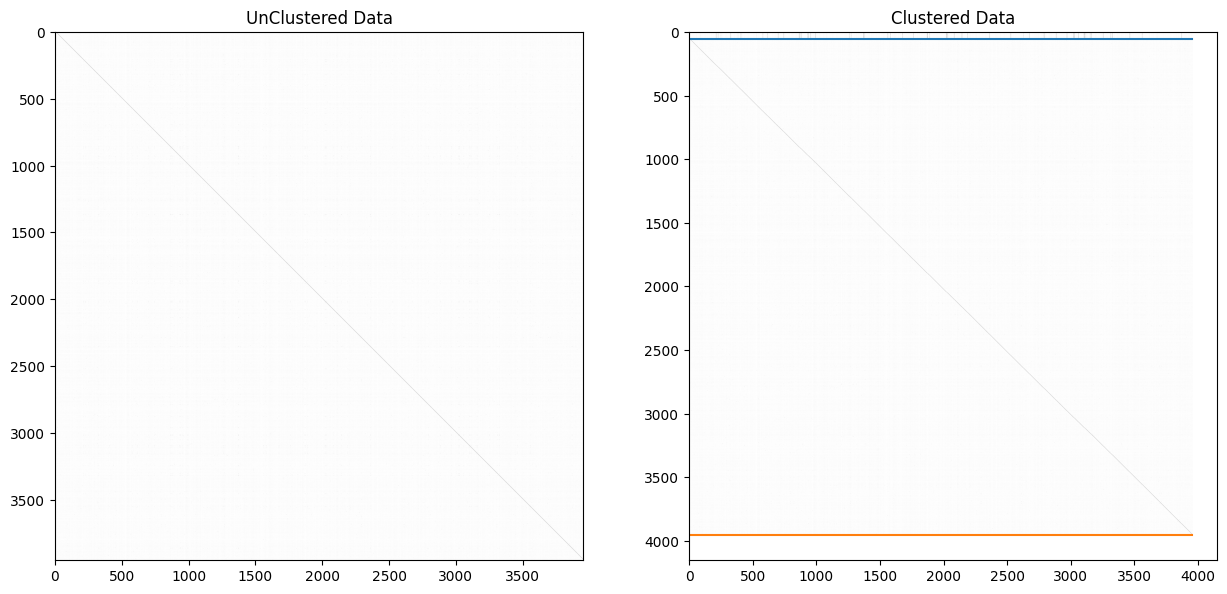

In [25]:
# Visualize Clustering in Distance Matrix

matrix_plot(enron_matrix, y_pred, k)


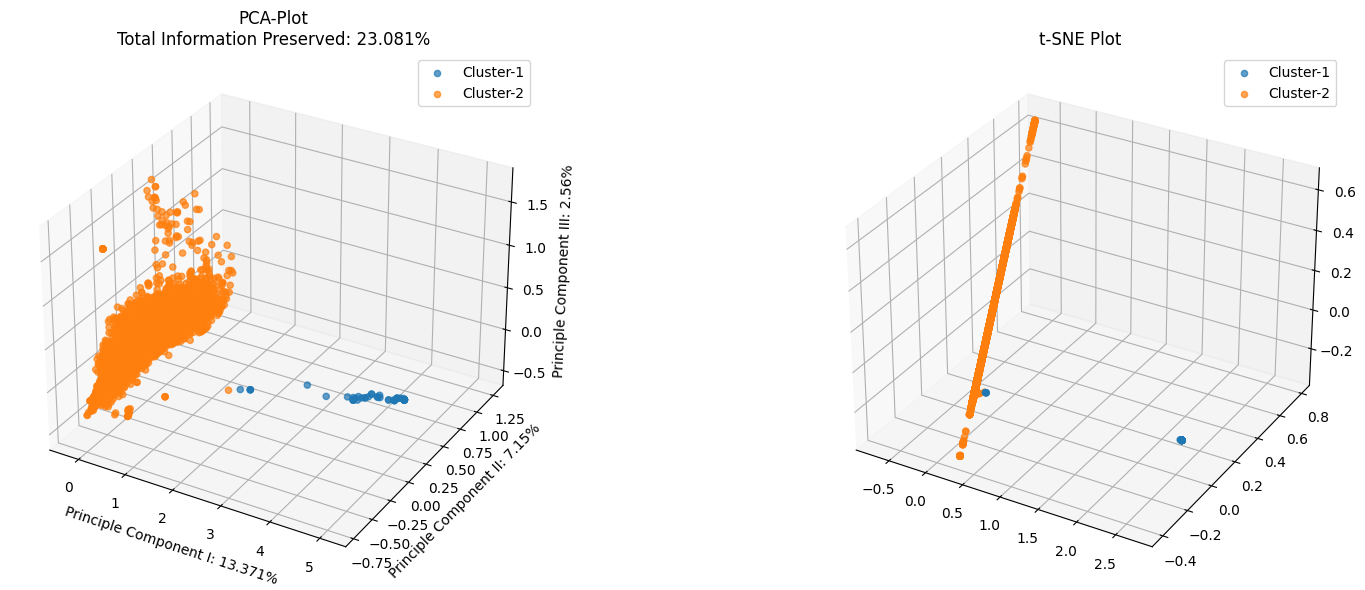

peak memory: 1784.79 MiB, increment: 119.91 MiB
CPU times: user 1min 17s, sys: 1.42 s, total: 1min 18s
Wall time: 46.7 s


In [26]:
%%time
%%memit

# Document Clustering Visualization

joint_plot(enron_matrix, y_pred)

In [27]:
id_Print(enron_matrix, kmeans.cluster_centers_, cd_enron_1)
evaluation_metrics(enron_matrix, y_pred)

Clusters:
Centroid-1: DocID-954 -> {8577, 6659, 12292, 19592, 19484, 23837, 17701, 18221, 5294, 942, 22064, 26680, 9404, 978, 6099, 14681, 9434, 6106, 25308, 15070, 1766, 8297, 22122, 11885, 11886, 22126, 22128, 12785, 7801, 6650, 15740, 21246}
Centroid-2: DocID-1148 -> {20481, 13826, 22531, 5125, 8201, 24073, 527, 23578, 21021, 1054, 22557, 18983, 1069, 22576, 3638, 19003, 1085, 16962, 9800, 17481, 26193, 8280, 9817, 17497, 11867, 22106, 22619, 14431, 26208, 15971, 2152, 27753, 2669, 20078, 21613, 27762, 23674, 9855, 7295, 5761, 2180, 21127, 25741, 2704, 24721, 24727, 9374, 16545, 13990, 12469, 8886, 19130, 7375, 5328, 26839, 16602, 5345, 8943, 20722, 14071, 250, 24314, 15617, 259, 17670, 7437, 20750, 25869, 14099, 21269, 17179, 26920, 21289, 21803, 22827, 6448, 10033, 14146, 10051, 12612, 9541, 9032, 1355, 14160, 9053, 22366, 1375, 23904, 28010, 22380, 9589, 13690, 14202, 378, 14204, 18299, 22915, 12676, 1926, 9607, 3474, 14738, 8596, 23956, 4510, 24993, 1445, 4518, 24485, 14252, 606